# Simulated Annealing Demo

Skrypt przedstawia przykładową implementację algorytmu symulowanego wyżarzania (ang. Simulated Annealing, SA) i jego zastosowanie do rozwiązywania problemu Quadratic Assignment Problem (QAP). Problem jest dokładnie opisany m.in. w pracy Burkarda i innych [1]. Popularne instancje problemu QAP można znaleźć w bibliotece QAPLib [2]. Skrypt skupia się na rozwiązywaniu instancji NUG12 [3], w celu rozwiązywania innych instancji może okazać się konieczna zmiana ustawień parametrów algorytmu.

Literatura:

[1]  Burkard, R., Cela, E., Pardalos, P., Pitsoulis, L., "The Quadratic Assignment Problem", http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.217.1914

[2] QAPLIB, http://anjos.mgi.polymtl.ca/qaplib/

[3] NUG12, http://anjos.mgi.polymtl.ca/qaplib/data.d/nug12.dat

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import urllib.request

%matplotlib inline

In [90]:
QAP_INSTANCE_URL = 'http://anjos.mgi.polymtl.ca/qaplib/data.d/nug12.dat'

## Reading input data

In [91]:
def read_data(URL):
    qap_instance_file = urllib.request.urlopen(URL)

    line = qap_instance_file.readline()
    n = int(line.decode()[:-1].split()[0])
    print('Problem size: %d' % n)

    A = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        A[i, :] = list(map(int, line.decode()[:-1].split()))
    print('Flow matrix:\n', A)

    B = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        B[i, :] = list(map(int, line.decode()[:-1].split()))
    print('Distance matrix:\n', B)
    return n, A, B
n, A, B = read_data(QAP_INSTANCE_URL)

Problem size: 12
Flow matrix:
 [[0. 1. 2. 3. 1. 2. 3. 4. 2. 3. 4. 5.]
 [1. 0. 1. 2. 2. 1. 2. 3. 3. 2. 3. 4.]
 [2. 1. 0. 1. 3. 2. 1. 2. 4. 3. 2. 3.]
 [3. 2. 1. 0. 4. 3. 2. 1. 5. 4. 3. 2.]
 [1. 2. 3. 4. 0. 1. 2. 3. 1. 2. 3. 4.]
 [2. 1. 2. 3. 1. 0. 1. 2. 2. 1. 2. 3.]
 [3. 2. 1. 2. 2. 1. 0. 1. 3. 2. 1. 2.]
 [4. 3. 2. 1. 3. 2. 1. 0. 4. 3. 2. 1.]
 [2. 3. 4. 5. 1. 2. 3. 4. 0. 1. 2. 3.]
 [3. 2. 3. 4. 2. 1. 2. 3. 1. 0. 1. 2.]
 [4. 3. 2. 3. 3. 2. 1. 2. 2. 1. 0. 1.]
 [5. 4. 3. 2. 4. 3. 2. 1. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0.  5.  2.  4.  1.  0.  0.  6.  2.  1.  1.  1.]
 [ 5.  0.  3.  0.  2.  2.  2.  0.  4.  5.  0.  0.]
 [ 2.  3.  0.  0.  0.  0.  0.  5.  5.  2.  2.  2.]
 [ 4.  0.  0.  0.  5.  2.  2. 10.  0.  0.  5.  5.]
 [ 1.  2.  0.  5.  0. 10.  0.  0.  0.  5.  1.  1.]
 [ 0.  2.  0.  2. 10.  0.  5.  1.  1.  5.  4.  0.]
 [ 0.  2.  0.  2.  0.  5.  0. 10.  5.  2.  3.  3.]
 [ 6.  0.  5. 10.  0.  1. 10.  0.  0.  0.  5.  0.]
 [ 2.  4.  5.  0.  0.  1.  5.  0.  0.  0. 10. 10.]
 [ 1.  5.  2.  0.  5.  

## Objective function

In [36]:
def qap_objective_function(p):
    s = 0.0
    for i in range(n):
        s += (A[i, :] * B[p[i], p]).sum()
    return s

In [92]:
p = [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]
print(qap_objective_function(p), p)

578.0 [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]


## Random Sampling

In [44]:
t0 = time.time()

T = 1000000

permutations = np.empty((T, n), dtype=np.int64)
costs = np.zeros(T)
for i in range(T):
    permutations[i, :] = np.random.permutation(n)
    costs[i] = qap_objective_function(permutations[i, :])

print(time.time() - t0)

p = permutations[costs.argmin(), :]
print(qap_objective_function(p), p)

68.32961249351501
608.0 [ 8 10  1  9 11  6  0  5  2  7  3  4]


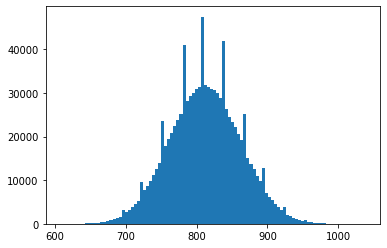

812.029156 49.73114000229297


In [45]:
plt.figure()
plt.hist(costs, bins=100)
plt.show()

print(costs.mean(), costs.std())

## Simulated Annealing

In [9]:
def random_neighbor(p, radius):
    q = p.copy()
    for r in range(radius):
        i, j = np.random.choice(n, 2, replace=False)
        q[i], q[j] = q[j], q[i]
    return q

In [93]:
def simulated_annaling(n, T=500000, radius=1, alpha=1.0):
    t0 = time.time()

    p = np.random.permutation(n)
    p_cost = qap_objective_function(p)
    costs = np.zeros(T)
    for t in range(T):
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
        costs[t] = p_cost

    print(time.time() - t0, costs.min())
    return costs, p
costs = simulated_annaling(n)    

45.82171607017517 578.0


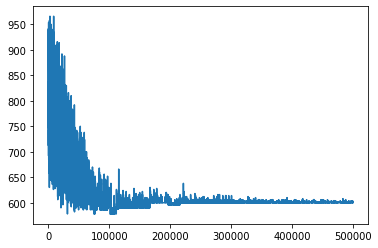

In [49]:
plt.figure()
plt.plot(costs)
plt.show()

# zad 1 a)

In [54]:
n, A, B = read_data('http://anjos.mgi.polymtl.ca/qaplib/data.d/nug14.dat')

Problem size: 14
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0. 10.  0.  5.  1.  0.  1.  2.  2.  2.  2.  0.  4.  0.]
 [10.  0.  1.  3.  2.  2.  2.  3.  2.  0.  2.  0. 10.  5.]
 [ 0.  1.  0. 10.  2.  0.  2.  5.  4.  5.  2.  2.  5.  5.]
 [ 5.  3. 10.  0.  1.  1.  5.  0.  0.  2.  1.  0.  2.  5.]
 [ 1.  2.  2.  1.  0.  3.  5.  5.  5.  1.  0.  3.  0.  5.]
 [ 0.  2.  0.  1.  3.  0.

In [55]:
p = [8, 7, 12, 1, 0, 10, 6, 13, 2, 3, 11, 4, 5, 9]
print(qap_objective_function(p), p)

1014.0 [8, 7, 12, 1, 0, 10, 6, 13, 2, 3, 11, 4, 5, 9]


In [56]:
costs = simulated_annaling(n)   

51.273181438446045 1014.0


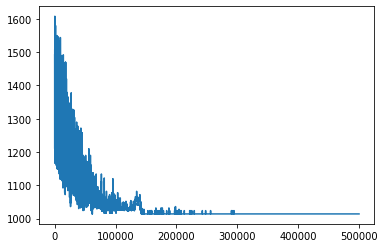

In [57]:
plt.figure()
plt.plot(costs)
plt.show()

In [58]:
n, A, B = read_data('http://anjos.mgi.polymtl.ca/qaplib/data.d/nug15.dat')

Problem size: 15
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2. 3.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 2.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1.]
 [6. 5. 4. 3. 2. 5. 4. 3. 2. 1. 4. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0. 10.  0.  5.  1.  0.  1.  2.  2.  2.  2.  0.  4.  0.  0.]
 [10.  0.  1.  3.  2.  2.  2.  3.  2.  0.  2.  0. 10.  5.  0.]
 [ 0.  1.  0. 10.  2.  0.  2.  5.  4.  5.  2.  2.  5.  5.  5.]
 [ 5.  3. 10.  0.  1.  1.  5.  0.  0.  2.

In [60]:
p = [0, 1, 12, 7, 8, 3, 2, 13, 6, 10, 9, 14, 5, 4, 11]
print(qap_objective_function(p), p)

1150.0 [0, 1, 12, 7, 8, 3, 2, 13, 6, 10, 9, 14, 5, 4, 11]


In [61]:
costs = simulated_annaling(n)

53.397709608078 1150.0


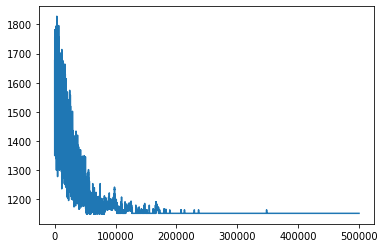

In [62]:
plt.figure()
plt.plot(costs)
plt.show()

In [476]:
n, A, B = read_data('http://anjos.mgi.polymtl.ca/qaplib/data.d/nug17.dat')

Problem size: 17
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6. 3. 4.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4. 3.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3. 6. 5.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2. 7. 6.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3.]
 [6. 5. 4. 3. 2. 5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4.]
 [3. 4. 5. 6. 7. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1.]
 [4. 3. 4. 5. 6. 3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0.]]
Distance matrix:
 [[ 0.  0.  5.  0.  5.  2. 10.  3

In [477]:
p = [ x - 1 for x in [16,15,2,14,9,11,8,12,10,3,4,1,7,6,13,17,5]]
print(qap_objective_function(p), p)

1732.0 [15, 14, 1, 13, 8, 10, 7, 11, 9, 2, 3, 0, 6, 5, 12, 16, 4]


In [495]:
costs, _ = simulated_annaling(n, radius=3, alpha=1.2, T=2000000)

310.2268524169922 1742.0


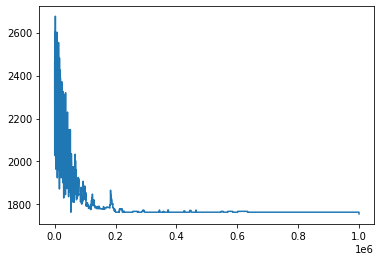

In [494]:
plt.figure()
plt.plot(costs)
plt.show()

In [85]:
n, A, B = read_data('http://anjos.mgi.polymtl.ca/qaplib/data.d/nug20.dat')

Problem size: 20
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6. 3. 4. 5. 6. 7.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4. 3. 4. 5. 6.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4. 3. 4. 5.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3. 6. 5. 4. 3. 4.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2. 7. 6. 5. 4. 3.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2.]
 [6. 5. 4. 3. 2. 5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1.]
 [3. 4. 5. 6. 7. 2. 3. 4

In [86]:
p = [ x - 1 for x in [18,14,10,3,9,4,2,12,11,16,19,15,20,8,13,17,5,7,1,6]]
print(qap_objective_function(p), p)

2570.0 [17, 13, 9, 2, 8, 3, 1, 11, 10, 15, 18, 14, 19, 7, 12, 16, 4, 6, 0, 5]


In [481]:
costs = simulated_annaling(n, radius=2, alpha=1.2)

68.58410453796387 1768.0


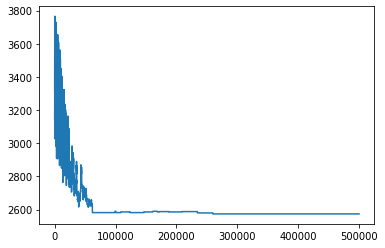

In [88]:
plt.figure()
plt.plot(costs)
plt.show()

## zad1 b)

In [177]:
n, A, B = read_data('http://anjos.mgi.polymtl.ca/qaplib/data.d/nug15.dat')

t0 = time.time()

T = 200

results = np.empty((T, n), dtype=np.int64)
costs = np.zeros(T)
for i in range(T):
    _, results[i, :] = simulated_annaling(n, radius=6, alpha=1.4, T=200000)
    costs[i] = qap_objective_function(results[i, :])

print(time.time() - t0)

p = results[costs.argmin(), :]
print(qap_objective_function(p), p)

Problem size: 15
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2. 3.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 2.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1.]
 [6. 5. 4. 3. 2. 5. 4. 3. 2. 1. 4. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0. 10.  0.  5.  1.  0.  1.  2.  2.  2.  2.  0.  4.  0.  0.]
 [10.  0.  1.  3.  2.  2.  2.  3.  2.  0.  2.  0. 10.  5.  0.]
 [ 0.  1.  0. 10.  2.  0.  2.  5.  4.  5.  2.  2.  5.  5.  5.]
 [ 5.  3. 10.  0.  1.  1.  5.  0.  0.  2.

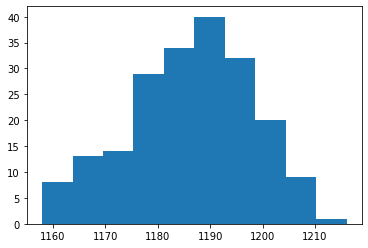

1186.25 11.988223387975385


In [178]:
plt.figure()
plt.hist(costs, bins=10)
plt.show()

print(costs.mean(), costs.std())

## zad1 c)

In [114]:
n, A, B = read_data('http://anjos.mgi.polymtl.ca/qaplib/data.d/nug15.dat')

def simulated_annaling_c(n, T=500000, radius=1, alpha=1.0):
    t0 = time.time()

    p = np.random.permutation(n)
    p_cost = qap_objective_function(p)
    costs = np.zeros(T)
    succ = np.zeros(T // 1000)
    for t in range(T):
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q)
        if(q_cost < p_cost):
            succ[t // 1000] += 1
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
            succ[t // 1000] += 1
        costs[t] = p_cost

    print(time.time() - t0, costs.min())
    return costs, succ

Problem size: 15
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2. 3.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 2.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1.]
 [6. 5. 4. 3. 2. 5. 4. 3. 2. 1. 4. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0. 10.  0.  5.  1.  0.  1.  2.  2.  2.  2.  0.  4.  0.  0.]
 [10.  0.  1.  3.  2.  2.  2.  3.  2.  0.  2.  0. 10.  5.  0.]
 [ 0.  1.  0. 10.  2.  0.  2.  5.  4.  5.  2.  2.  5.  5.  5.]
 [ 5.  3. 10.  0.  1.  1.  5.  0.  0.  2.

42.93378210067749 1150.0


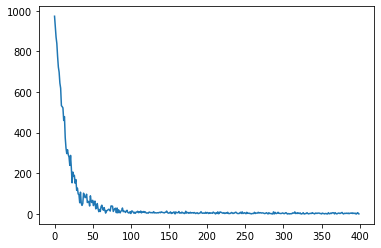

In [115]:
_, succ = simulated_annaling_c(n, radius=1, alpha=1.0, T=400000)
plt.figure()
plt.plot(succ)
plt.show()

63.344176054000854 1170.0


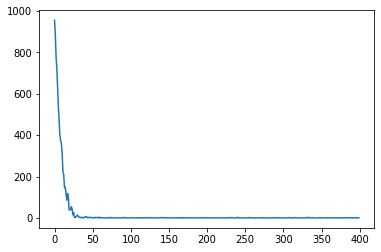

In [116]:
_, succ = simulated_annaling_c(n, radius=4, alpha=1.0, T=400000)
plt.figure()
plt.plot(succ)
plt.show()

43.05525493621826 1152.0


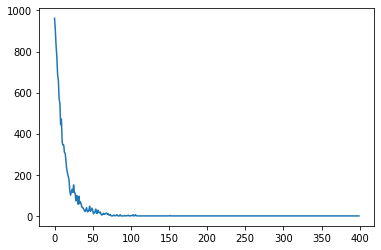

In [117]:
_, succ = simulated_annaling_c(n, radius=1, alpha=1.4, T=400000)
plt.figure()
plt.plot(succ)
plt.show()

103.23290228843689 1214.0


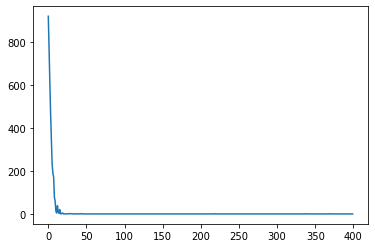

In [118]:
_, succ = simulated_annaling_c(n, radius=10, alpha=1.6, T=400000)
plt.figure()
plt.plot(succ)
plt.show()

49.97214698791504 1152.0


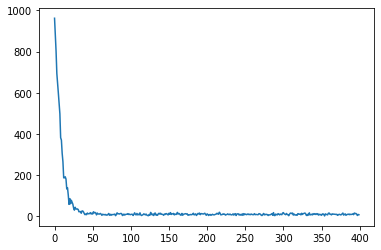

In [119]:
_, succ = simulated_annaling_c(n, radius=2, alpha=1.2, T=400000)
plt.figure()
plt.plot(succ)
plt.show()

## zad1 d)

In [122]:
def hamming_distance(p1, p2):
    return sum([0 if a == b else 1 for a,b in zip(p1, p2)])

print(hamming_distance([1,2,3], [1,2,3]))
print(hamming_distance([1,2,3], [1,2,1]))
print(hamming_distance([1,2,3], [5,5,1]))


0
1
3


In [473]:
n, A, B = read_data('http://anjos.mgi.polymtl.ca/qaplib/data.d/nug20.dat')

def simulated_annaling_d(n, T=500000, radius=1, alpha=1.0):
    t0 = time.time()

    p = np.random.permutation(n)
    p_cost = qap_objective_function(p)
    costs = np.zeros(T)
    succ_dist = [[] for _ in range(n+1)]
    for t in range(T):
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q)
        if(q_cost < p_cost):
            succ_dist[hamming_distance(q, p)].append(p_cost - q_cost)
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
        costs[t] = p_cost

    print(time.time() - t0, costs.min())
    return costs, succ_dist

Problem size: 20
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6. 3. 4. 5. 6. 7.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4. 3. 4. 5. 6.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4. 3. 4. 5.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3. 6. 5. 4. 3. 4.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2. 7. 6. 5. 4. 3.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2.]
 [6. 5. 4. 3. 2. 5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1.]
 [3. 4. 5. 6. 7. 2. 3. 4

In [474]:
_, succ_dist = simulated_annaling_d(n, radius=10, alpha=1.2, T=200000)

55.64122438430786 2792.0


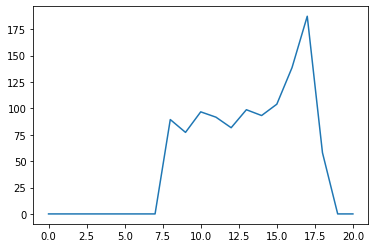

In [475]:
plt.figure()
plt.plot([0 if len(x) == 0 else sum(x) / len(x) for x in succ_dist])
plt.show()

## ZAD 2

In [392]:
def pbil(F, d=10, N=20, θ1=0.1, θ2=0.05, θ3=0.1, T=50):
    def binary_random(p):
        return 1 if np.random.rand(1)[0] < p else 0
    
    def initial_prop_vector():
        p = np.array(np.empty(d))
        p[:] = 0.5
        return p
    
    def random_individual(p):
        return [binary_random(pk) for pk in p]
        
    def random_population(p):
        return [random_individual(p) for _ in range(N)]
        
    p = initial_prop_vector()
    P = random_population(p)
    hist = []
    for _ in range(T):
        cost, best = max([(F(i), i) for i in P], key=lambda x: x[0])
        hist.append(cost)
        p = [pk * (1.0 - θ1) + xik * θ1 for pk, xik in zip(p, best)]
        
        for k in range(d):
            if np.random.rand(1)[0] < θ2:
                p[k] = p[k] * (1 - θ3) + np.random.choice([0, 1]) * θ3
        
        P = random_population(p)
    return best, hist


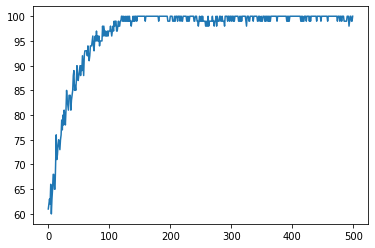

In [409]:
best, hist = pbil(F=sum, d=100, T=500) #oneMax
plt.figure()
plt.plot(hist)
plt.show()

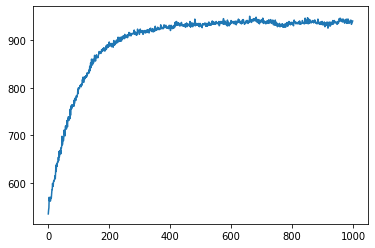

In [417]:
best, hist = pbil(F=sum, d=1000, T=1000, N=200)
plt.figure()
plt.plot(hist)
plt.show()

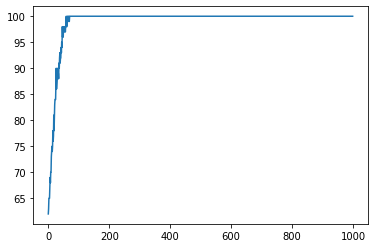

In [405]:
## Deceptive OneMax
def dec_oneMax(v):
    s = sum(v)
    return s if s != 0 else len(v) + 1

best, hist = pbil(F=dec_oneMax, d=100, T=1000, N=100)
plt.figure()
plt.plot(hist)
plt.show()

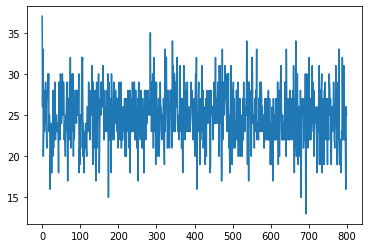

In [427]:
best, hist = pbil(F=dec_oneMax, d=50, T=800, N=10000, θ1=0.1, θ2=1.0, θ3=1.0)
plt.figure()
plt.plot(hist)
plt.show()

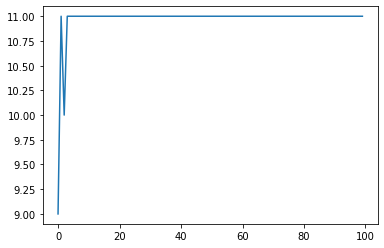

In [442]:
best, hist = pbil(F=dec_oneMax, d=10, T=100, N=500, θ1=0.1, θ2=0.1, θ3=0.4)
plt.figure()
plt.plot(hist)
plt.show()

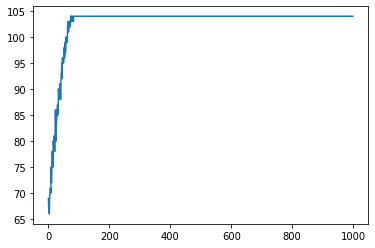

In [470]:
## K-DeceptiveOneMax
def kdec_oneMax(v):
    K = 5
    chunks = [v[x:x+K] for x in range(0, len(v), K)]
    return sum([dec_oneMax(x) for x in chunks])

best, hist = pbil(F=kdec_oneMax, d=100, T=1000, N=100)
plt.figure()
plt.plot(hist)
plt.show()

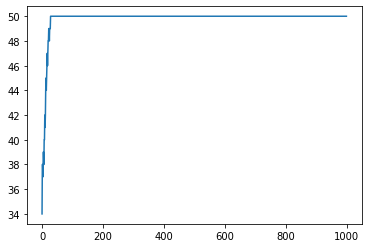

In [454]:
best, hist = pbil(F=kdec_oneMax, d=50, T=1000, N=500)
plt.figure()
plt.plot(hist)
plt.show()

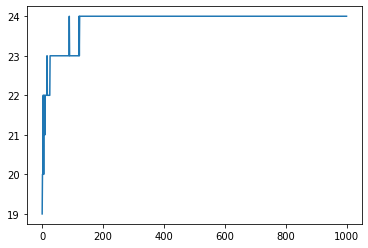

In [472]:
best, hist = pbil(F=kdec_oneMax, d=20, T=1000, N=4000, θ1=0.1, θ2=0.3, θ3=0.2)
plt.figure()
plt.plot(hist)
plt.show()

## zad3

In [354]:
rules = []
with open('ClassificationRules.txt') as frules:
    for line in frules:
        rules.append([int(c.split('.')[0]) for c in line.strip().split(' ') if c])

expert = None
with open('ImageExpertReduced.txt') as expert:
    for line in expert:
        expert = [int(c.split('.')[0]) for c in line.strip().split(' ') if c]
expert = np.array(expert)
print(len(expert), len(rules))

9350 266


In [389]:
def cost_function(p):
    used_rules = []
    for i,pk in enumerate(p):
       if pk:
        used_rules.append(rules[i])
    return np.sum(np.array([np.argmax(np.bincount(x)) for x in np.stack(used_rules).transpose()]) == expert)


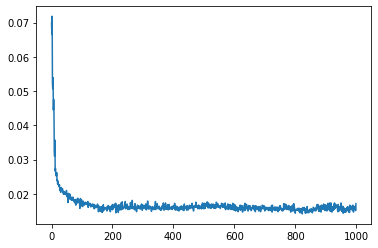

In [411]:
best, hist = pbil(F=cost_function, d=266, T=1000, N=125)
plt.figure()
hist = [1 - (x / 9350) for x in hist]
plt.plot(hist)
plt.show()

In [412]:
print(min(hist))

0.014117647058823568
